In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
from scipy import stats
from config import config_dict
import os
import neurodsp
import itertools
from bisect import bisect_left
from statsmodels.stats.proportion import proportion_confint
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('Cole_2018.mplstyle')

pd.options.display.max_columns=200
pd.options.display.max_rows=100

In [2]:
# Make directory for saving figures
if not os.path.exists('figs/6'):
    os.makedirs('figs/6')

# Load lfp and neuron stats

In [3]:
# Load shank stats
df_shanks = pd.read_csv(config_dict['processed_path'] + 'df_shanks_stats.csv', index_col=0)
df_shanks = df_shanks[df_shanks['burst_type']==0].reset_index()

# Load neuron stats
df_neus = pd.read_csv(config_dict['processed_path'] + 'df_neus_stats.csv', index_col=0)

# Load neuron pairs stats
df_neu_pairs = pd.read_csv(config_dict['processed_path'] + 'df_neuron_pairs.csv', index_col=0)
df_neu_pairs = df_neu_pairs[df_neu_pairs['burst_type']==0]
df_neu_pairs = df_neu_pairs[df_neu_pairs['synchrony_ms']==config_dict['analysis_synchrony_ms']]

### Merge in neuron properties into neuron pairs df

In [4]:
df_neus_cols = ['rat', 'sess', 'sh', 'clu',
                'sfc_magnitude_cycles', 'sfc_phase_cycles', 'type']

df_neu_pairs = df_neu_pairs.merge(df_neus[df_neus_cols],
                                  left_on = ['rat', 'sess', 'sh', 'clu1'],
                                  right_on = ['rat', 'sess', 'sh', 'clu'])
df_neu_pairs = df_neu_pairs.rename({'fr_cycles': 'clu1_fr',
                                    'sfc_magnitude_cycles': 'clu1_sfc_mag',
                                    'sfc_phase_cycles': 'clu1_sfc_pha',
                                    'type': 'clu1_type'}, axis=1)
df_neu_pairs = df_neu_pairs.drop('clu', axis=1)
df_neu_pairs = df_neu_pairs.merge(df_neus[df_neus_cols], left_on = ['rat', 'sess', 'sh', 'clu2'], right_on= ['rat', 'sess', 'sh', 'clu'])
df_neu_pairs = df_neu_pairs.rename({'fr_cycles': 'clu2_fr',
                                    'sfc_magnitude_cycles': 'clu2_sfc_mag',
                                    'sfc_phase_cycles': 'clu2_sfc_pha',
                                    'type': 'clu2_type'}, axis=1)
df_neu_pairs = df_neu_pairs.drop('clu', axis=1)

# Add Fs to neu pairs
df_neu_pairs = df_neu_pairs.merge(df_shanks[['rat','sess','sh','Fs']],
                                  on=['rat','sess','sh'], how='left')

In [5]:
# Define hyperparameters of analysis
ms = config_dict['analysis_synchrony_ms']
min_N_sync_spikes = config_dict['analysis_N_sync_min']

# A-D. Synchrony ~ rdsym and ptsym

In [6]:
# Compute differences in average feature between sync and nonsync
feats = ['volt_amp', 'period', 'time_rdsym', 'time_ptsym']
for feat in feats:
    df_neu_pairs[feat+'_sync_diff'] = (df_neu_pairs[feat+'_sync_mean'] - \
                                       df_neu_pairs[feat+'_nonsync_mean']) / df_neu_pairs[feat+'_nonsync_mean']


In [7]:
# Synchrony relation to all features
feats = ['volt_amp', 'period', 'time_rdsym', 'time_ptsym']
for neutype in ['p', 'i']:
    df_temp = df_neu_pairs[(df_neu_pairs['clu1_type']==neutype) &
                           (df_neu_pairs['clu2_type']==neutype)]
    df_temp = df_temp[df_temp['N_sync_spikes_bursting']>=min_N_sync_spikes]
    
    # Number of each neuron for analysis
    print('# neuron pairs =', len(df_temp))
    
    for feat in feats:
        W, p = stats.wilcoxon(df_temp[feat+'_sync_diff'].dropna())
        effect = df_temp[feat+'_sync_diff'].dropna().mean()
        print('{:s} {:10s}, W= {:.0f}, p = {:.1E}, Synchrony changes {:10s} on average by {:.1f}%'.format(neutype, feat, W, p, feat, effect*100))

# neuron pairs = 431
p volt_amp  , W= 24119, p = 4.4E-18, Synchrony changes volt_amp   on average by 2.1%
p period    , W= 30573, p = 6.7E-10, Synchrony changes period     on average by -0.9%
p time_rdsym, W= 43440, p = 2.3E-01, Synchrony changes time_rdsym on average by -0.3%
p time_ptsym, W= 39459, p = 6.1E-03, Synchrony changes time_ptsym on average by -0.5%
# neuron pairs = 46
i volt_amp  , W= 179, p = 7.8E-05, Synchrony changes volt_amp   on average by 4.2%
i period    , W= 26, p = 1.9E-08, Synchrony changes period     on average by -3.0%
i time_rdsym, W= 123, p = 5.1E-06, Synchrony changes time_rdsym on average by -3.2%
i time_ptsym, W= 358, p = 4.6E-02, Synchrony changes time_ptsym on average by -0.8%


/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  app.launch_new_instance()
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  app.launch_new_instance()
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  app.launch_new_instance()
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  app.launch_new_instance()


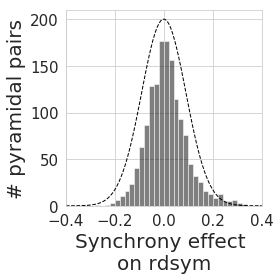

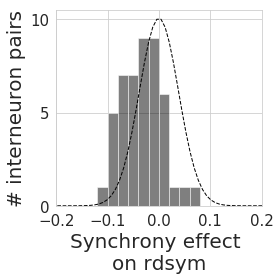

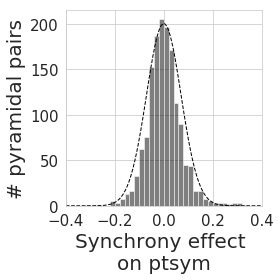

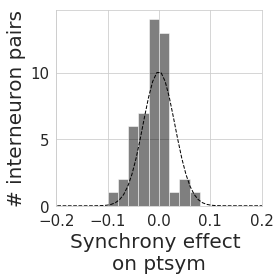

In [8]:
for feat, feat_name, letters in zip(['time_rdsym', 'time_ptsym'],
                                    ['rdsym', 'ptsym'],
                                    [['A', 'B'], ['C', 'D']]):
    for neutype, name, letter, yticks, xticks in zip(['p', 'i'], ['pyramidal', 'interneuron'], letters,
                                           [np.arange(0, 201, 50), np.arange(0, 11, 5)], [np.arange(-.4,.41,.2), np.arange(-.2,.21,.1)]):

        df_temp = df_neu_pairs[(df_neu_pairs['clu1_type']==neutype) &
                               (df_neu_pairs['clu2_type']==neutype)]

        plt.figure(figsize=(4,4))
        plt.hist(df_temp[feat+'_sync_diff'].dropna(), color='k',
                 bins=np.arange(-.4, .41, .02), alpha=.5)

        # Plot null Gaussian
        x_gauss = np.linspace(-.4, .4, 100)
        y_gauss = mlab.normpdf(x_gauss, 0, np.std(df_temp[feat+'_sync_diff'].dropna()))
        y_gauss = y_gauss * yticks[-1] / np.max(y_gauss)
        plt.plot(x_gauss, y_gauss, 'k--')

        plt.xticks(xticks)
        plt.xlim((xticks[0], xticks[-1]))
        plt.yticks(yticks)
        plt.ylabel('# {:s} pairs'.format(name))
        plt.xlabel('Synchrony effect \non {:s}'.format(feat_name))
        plt.tight_layout()
        plt.savefig('figs/6/{:s}.png'.format(letter))

### Synchrony between P and I neurons
Same trends as within P and I neurons

In [9]:
df_temp = df_neu_pairs[((df_neu_pairs['clu1_type']=='p') &
                       (df_neu_pairs['clu2_type']=='i')) |
                      ((df_neu_pairs['clu1_type']=='i') &
                       (df_neu_pairs['clu2_type']=='p'))]

df_temp = df_temp[df_temp['N_sync_spikes_bursting']>=min_N_sync_spikes]

# Number of each neuron for analysis
print('# neuron pairs =', len(df_temp))

for feat in feats:
    W, p = stats.wilcoxon(df_temp[feat+'_sync_diff'].dropna())
    effect = df_temp[feat+'_sync_diff'].dropna().mean()
    print('{:10s} W= {:.0f}, p = {:.1E}, Synchrony changes {:10s} on average by {:.1f}%'.format(feat, W, p, feat, effect*100))
    

# neuron pairs = 517
volt_amp   W= 32508, p = 3.9E-24, Synchrony changes volt_amp   on average by 2.7%
period     W= 25841, p = 1.1E-33, Synchrony changes period     on average by -1.8%
time_rdsym W= 51641, p = 6.6E-06, Synchrony changes time_rdsym on average by -0.8%
time_ptsym W= 47218, p = 6.4E-09, Synchrony changes time_ptsym on average by -1.0%


# E-F. Example neuron with significant symmetry ~ sequence relationships

In [10]:
def compute_sequence_col(last_spike, next_spike):
    if last_spike and not next_spike:
        return 'post'
    elif next_spike and not last_spike:
        return 'pre'
    else:
        return np.nan


def compute_df_seq(row, ms):
    dict_stats = defaultdict(list)
    
    # Load shape dataframe
    path_shape = config_dict['mat_path'] + '/' + row['rat'] + \
        '/' + row['sess'] + '/' + str(row['sh']) + '/cycle_by_cycle_shape.csv'
    df_shape = pd.read_csv(path_shape, index_col=0)

    # Load spiking
    f = np.load(config_dict['mat_path'] + row['rat'] + '/' + row['sess'] + '/neu_raster.npz')
    raster_times = f['raster_times_by_shank'][row['sh']]
    raster_neus = f['raster_neus_by_shank'][row['sh']]

    # Load neuron info
    df_neus_shank = df_neus[(df_neus['rat'] == row['rat']) &
                                  (df_neus['sess'] == row['sess']) &
                                  (df_neus['sh'] == row['sh'])]

    # Only consider neurons with a minimum number of spikes
    df_neus_shank = df_neus_shank[df_neus_shank['N_spikes_burst0'] >= min_N_sync_spikes]
    shank_clus = list(df_neus_shank['clu'])

    # Analyze pair of neus
    pair = (row['clu1'], row['clu2'])

    # Make spkt2 be the one with fewer spikes
    spkt1 = raster_times[raster_neus == pair[0]]
    spkt2 = raster_times[raster_neus == pair[1]]
    if len(spkt2) > len(spkt1):
        spkt1, spkt2 = spkt2, spkt1
        dict_stats['clu1'].append(pair[1])
        dict_stats['clu2'].append(pair[0])
    else:
        dict_stats['clu1'].append(pair[0])
        dict_stats['clu2'].append(pair[1])

    # For each spike in spkt2, find the next closest and most recent spike in spkt2
    spkt1 = np.insert(np.append(spkt1, np.inf), 0, -np.inf)
    next_spikes = np.array([spkt1[bisect_left(spkt1, x)] for x in spkt2])
    last_spikes = np.array([spkt1[bisect_left(spkt1, x)-1] for x in spkt2])

    # Make df of closest spikes
    df_pair = pd.DataFrame({'spike_time': spkt2 / row['Fs'],
                            'last_spike': last_spikes / row['Fs'],
                            'next_spike': next_spikes / row['Fs'],
                            'last_spike_dt': (spkt2 - last_spikes) / row['Fs'],
                            'next_spike_dt': (next_spikes - spkt2) / row['Fs']})
    df_pair = df_pair.replace([np.inf, -np.inf], np.nan).dropna()
    df_pair['closest_spike'] = df_pair[['last_spike_dt', 'next_spike_dt']].min(axis=1)

    # Get cycle information for each spike
    df_pair['cycle_number'] = [bisect_left(df_shape['sample_next_peak'], x) for x in df_pair['spike_time']*row['Fs']]
    df_pair = df_pair.merge(df_shape[['time_rdsym', 'volt_amp', 'time_ptsym', 'period', 'time_rise', 'is_burst0']],
                            left_on='cycle_number', right_index=True)
    df_pair['period'] = df_pair['period'] / row['Fs']
    df_pair['time_rise'] = df_pair['time_rise'] / row['Fs']

    # Save number of spikes
    dict_stats['N_spikes'].append(len(df_pair))

    # Determine if closest/next/last spike is within X ms
    df_sync = df_pair.copy()
    df_sync['spike_within_{:d}ms'.format(ms)] = df_sync['closest_spike'] < (ms / 1000)
    df_sync['last_spike_within_{:d}ms'.format(ms)] = df_sync['last_spike_dt'] <= (ms / 1000)
    df_sync['next_spike_within_{:d}ms'.format(ms)] = df_sync['next_spike_dt'] <= (ms / 1000)

    # Only analyze synchrony/sequence if the number of synchronous spikes is above some threshold
    N_sync_spikes = df_sync['spike_within_{:d}ms'.format(ms)].sum()
    dict_stats['N_sync_spikes_{:d}ms'.format(ms)].append(N_sync_spikes)

    # Test if difference in is_burst when neurons are synchronous vs asynchronous
    x1 = df_sync[df_sync['spike_within_{:d}ms'.format(ms)]]['is_burst0']
    x2 = df_sync[~df_sync['spike_within_{:d}ms'.format(ms)]]['is_burst0']
    count = np.array([x1.sum(), x2.sum()])
    nobs = np.array([len(x1), len(x2)])
    binom_p = stats.binom_test(count, nobs)
    dict_stats['is_burst_sync_p'].append(binom_p)
    dict_stats['is_burst_sync_mean'].append(np.mean(x1))
    dict_stats['is_burst_nonsync_mean'].append(np.mean(x2))

    # When testing synchrony, count each cycle once,
    # and remove cycle if spikes have different results
    df_cycles = df_sync[df_sync['is_burst0'] == 1]
    df_cycle_temp = df_cycles[['cycle_number', 'spike_within_{:d}ms'.format(ms)]].groupby('cycle_number').mean().reset_index()
    cycles_use = df_cycle_temp[df_cycle_temp['spike_within_{:d}ms'.format(ms)].isin([0, 1])]['cycle_number'].values
    df_temp = df_cycles[df_cycles['cycle_number'].isin(cycles_use)]
    df_temp = df_temp.drop_duplicates(subset=['cycle_number'])

    # Determine the sequence of spiking at each spike
    df_seq = df_sync.copy()
    df_seq['sequence_{:d}ms'.format(ms)] = df_seq.apply(
            lambda row: compute_sequence_col(row['last_spike_within_{:d}ms'.format(ms)],
                                             row['next_spike_within_{:d}ms'.format(ms)]), axis=1)

    # Remove some spikes for sequence analysis
    # e.g. don't want a burst of spkt2 followed by a spkt1 to be counted as a bunch of instances of a post-sequence
    # Determine which spikes occur within the window size of one another
    df_seq['time_to_last_spike'] = df_seq['spike_time'].diff()
    df_seq['last_spike_close'] = df_seq['closest_spike'] <= (2 * ms / 1000)
    df_seq['last_spike_previous'] = np.insert(df_seq['last_spike'].values[:-1], 0, np.nan)
    df_seq['next_spike_previous'] = np.insert(df_seq['next_spike'].values[:-1], 0, np.nan)

    # For each pair of spikes that occurs within the window size of another spike
    # Remove both spikes if their pre/post designations are opposite
    df_seq['last_spike_seq'] = np.insert(df_seq['sequence_{:d}ms'.format(ms)].values[:-1], 0, np.nan)
    df_seq['last_spike_seq'] = np.insert(df_seq['sequence_{:d}ms'.format(ms)].values[:-1], 0, np.nan)
    df_seq['remove_this_spike'] = (df_seq['last_spike_seq'] != df_seq['sequence_{:d}ms'.format(ms)]) & \
                                   ~df_seq['last_spike_seq'].isnull() & ~df_seq['sequence_{:d}ms'.format(ms)].isnull()
    df_seq['remove_last_spike'] = df_seq['remove_this_spike'].copy()

    # If pre/post designations are the same, remove the farther spike if both have the same closest_spike
    df_both_pre = df_seq[(df_seq['sequence_{:d}ms'.format(ms)]=='pre') &
                          (df_seq['last_spike_seq']=='pre') &
                          (df_seq['last_spike_close']==True)]
    df_both_post = df_seq[(df_seq['sequence_{:d}ms'.format(ms)]=='post') &
                           (df_seq['last_spike_seq']=='post') &
                           (df_seq['last_spike_close']==True)]

    # For spikes which the current and previous were 'pre',
    # mark last_spike for removal if next_spike==next_spike_previous
    spk_index_remove_last_spk = df_both_post[df_both_post['last_spike'] == df_both_post['last_spike_previous']].index
    df_seq.loc[spk_index_remove_last_spk, 'remove_last_spike'] = True

    # For spikes which the current and previous were 'post',
    # mark this_spike for removal if last_spike==last_spike_previous
    spk_index_remove_this_spk = df_both_pre[df_both_pre['next_spike'] == df_both_pre['next_spike_previous']].index
    df_seq.loc[spk_index_remove_this_spk, 'remove_this_spike'] = True

    # Remove rows of df_seq as appropriate
    rows_rmv1 = np.array(df_seq[df_seq['remove_this_spike']].index.tolist())
    rows_rmv2 = np.array(df_seq[df_seq['remove_last_spike']].index.tolist()) - 1
    rows_rmv = np.union1d(rows_rmv1, rows_rmv2)
    df_seq = df_seq.drop(rows_rmv)
    return df_seq

U = 950, p = 0.028
U = 1098, p = 0.001


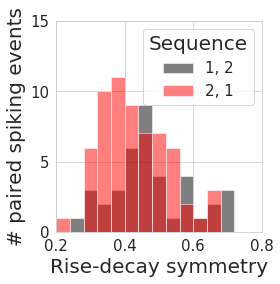

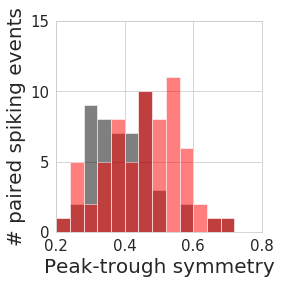

In [11]:
# Compute sequence difference for this time scale between theta vs. nontheta
bins = np.arange(.2, .81, .04)
neu_type = 'p'

# Only neurons of interest
df_temp = df_neu_pairs[(df_neu_pairs['clu1_type']==neu_type) &
                       (df_neu_pairs['clu2_type']==neu_type)]
df_temp = df_temp[df_temp['N_spikes_cycle_sequence']>=min_N_sync_spikes]

for feat, name, letter, idx_oi in zip(['time_rdsym', 'time_ptsym'],
                                      ['Rise-decay symmetry', 'Peak-trough symmetry'],
                                      ['E', 'F'],
                                      [1266, 1217]):
    row = df_neu_pairs.loc[idx_oi]
    
    df_seq10 = compute_df_seq(row, config_dict['analysis_synchrony_ms'])
    df_seq10 = df_seq10[df_seq10['is_burst0']]
    df_pre = df_seq10[df_seq10['sequence_{:d}ms'.format(ms)]=='pre']
    df_post = df_seq10[df_seq10['sequence_{:d}ms'.format(ms)]=='post']

    # Plot distributions of pre and post feature
    plt.figure(figsize=(4, 4))
    plt.hist(df_pre[feat], bins=bins, color='k', alpha=.5, label='1, 2')
    plt.hist(df_post[feat], bins=bins, color='r', alpha=.5, label='2, 1')
    plt.xlabel(name)
    plt.xlim((.2, .8))
    plt.yticks(np.arange(0, 16, 5))
    plt.ylabel('# paired spiking events')
    
    if feat == 'time_rdsym':
        legend = plt.legend(fontsize=15, title='Sequence')
        legend.get_title().set_fontsize('20')
        
    plt.tight_layout()
    plt.savefig('figs/6/{:s}.png'.format(letter))

    U, p = stats.mannwhitneyu(df_pre[feat], df_post[feat])
    print('U = {:.0f}, p = {:.3f}'.format(U, p))

# G. PY and IN sequence biased by theta features

In [12]:
df_neu_pairs_raw = pd.read_csv(config_dict['processed_path'] + 'df_neuron_pairs.csv', index_col=0)
df_neu_pairs_raw = df_neu_pairs_raw[df_neu_pairs_raw['burst_type']==0]

df_neus_cols = ['rat', 'sess', 'sh', 'clu',
                'sfc_magnitude_cycles', 'sfc_phase_cycles', 'type']

df_neu_pairs_raw = df_neu_pairs_raw.merge(df_neus[df_neus_cols],
                                  left_on = ['rat', 'sess', 'sh', 'clu1'],
                                  right_on = ['rat', 'sess', 'sh', 'clu'])
df_neu_pairs_raw = df_neu_pairs_raw.rename({'fr_cycles': 'clu1_fr',
                                    'sfc_magnitude_cycles': 'clu1_sfc_mag',
                                    'sfc_phase_cycles': 'clu1_sfc_pha',
                                    'type': 'clu1_type'}, axis=1)
df_neu_pairs_raw = df_neu_pairs_raw.drop('clu', axis=1)
df_neu_pairs_raw = df_neu_pairs_raw.merge(df_neus[df_neus_cols], left_on = ['rat', 'sess', 'sh', 'clu2'], right_on= ['rat', 'sess', 'sh', 'clu'])
df_neu_pairs_raw = df_neu_pairs_raw.rename({'fr_cycles': 'clu2_fr',
                                    'sfc_magnitude_cycles': 'clu2_sfc_mag',
                                    'sfc_phase_cycles': 'clu2_sfc_pha',
                                    'type': 'clu2_type'}, axis=1)
df_neu_pairs_raw = df_neu_pairs_raw.drop('clu', axis=1)

# Add Fs to neu pairs
df_neu_pairs_raw = df_neu_pairs_raw.merge(df_shanks[['rat','sess','sh','Fs']],
                                  on=['rat','sess','sh'], how='left')

In [13]:
p_cutoff = .05
neu_types = ['p', 'i']
names = {'p': 'pyramidal', 'i': 'interneuron'}
twindows = np.arange(10, 51, 10)
feats = ['volt_amp', 'period', 'time_rdsym', 'time_ptsym']

dict_sig = defaultdict(list)
for neu_type in neu_types:
    df_type = df_neu_pairs_raw[(df_neu_pairs_raw['clu1_type']==neu_type) &
                               (df_neu_pairs_raw['clu2_type']==neu_type)]
    for twindow in twindows:
        df_temp = df_type[df_type['synchrony_ms']==twindow]
        df_temp = df_temp[df_temp['N_spikes_cycle_sequence']>=min_N_sync_spikes]
        for feat in feats:
            x = df_temp[feat+'_seqprepost_p']
            p = stats.binom_test((x<.05).sum(), len(x), p=p_cutoff)
            conf_int = proportion_confint((x<.05).sum(), len(x), method = 'binom_test')
            dict_sig['neu'].append(names[neu_type])
            dict_sig['ms'].append(twindow)
            dict_sig['feature'].append(feat)
            dict_sig['p'].append(p)
            dict_sig['N_significant'].append((x<.05).sum())
            dict_sig['fraction_significant'].append((x<.05).sum()/len(x))
            dict_sig['N'].append(len(x))
            dict_sig['conf_int_low'].append(conf_int[0])
            dict_sig['conf_int_hi'].append(conf_int[1])
df_sig = pd.DataFrame(dict_sig)
df_sig.head(20)

,neu,ms,feature,p,N_significant,fraction_significant,N,conf_int_low,conf_int_hi
0,pyramidal,10,volt_amp,8.540906e-05,20,0.130719,153,0.083879,0.195305
1,pyramidal,10,period,2.174951e-03,17,0.111111,153,0.067335,0.172387
2,pyramidal,10,time_rdsym,1.361666e-02,15,0.098039,153,0.057467,0.156093
3,pyramidal,10,time_ptsym,2.174951e-03,17,0.111111,153,0.067335,0.172387
4,pyramidal,20,volt_amp,7.286276e-10,41,0.147482,278,0.109203,0.193918
5,pyramidal,20,period,5.504766e-17,53,0.190647,278,0.147001,0.240741
6,pyramidal,20,time_rdsym,2.209769e-03,26,0.093525,278,0.064146,0.134412
7,pyramidal,20,time_ptsym,2.368432e-06,34,0.122302,278,0.087597,0.166848
8,pyramidal,30,volt_amp,3.238728e-17,62,0.171271,362,0.135022,0.213838
9,pyramidal,30,period,3.606928e-12,53,0.146409,362,0.110114,0.183446


/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


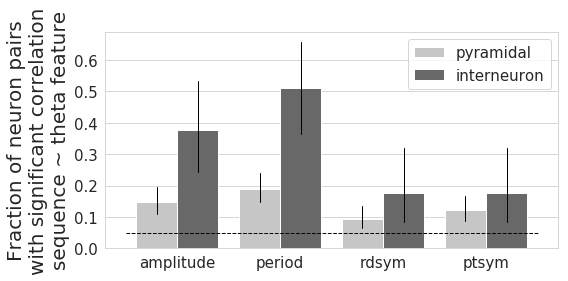

In [14]:
# Visualize significance
df_plt = df_sig[df_sig['ms']==ms]
df_plt.replace({'time_rdsym': 'rdsym', 'time_ptsym': 'ptsym', 'volt_amp': 'amplitude'}, inplace=True)
plt.figure(figsize=(8,4))
sns.barplot(x='feature', y='fraction_significant', hue='neu',
            data=df_plt, palette='Greys')

# Plot error bars
feats_temp = ['amplitude', 'period', 'rdsym', 'ptsym']
for i, feat in enumerate(feats_temp):
    cf_low = df_plt[(df_plt['feature']==feat) & (df_plt['neu']=='pyramidal')]['conf_int_low'].values[0]
    cf_hi = df_plt[(df_plt['feature']==feat) & (df_plt['neu']=='pyramidal')]['conf_int_hi'].values[0]
    plt.plot([i-.2,i-.2], [cf_low, cf_hi], 'k-')
    
    cf_low = df_plt[(df_plt['feature']==feat) & (df_plt['neu']=='interneuron')]['conf_int_low'].values[0]
    cf_hi = df_plt[(df_plt['feature']==feat) & (df_plt['neu']=='interneuron')]['conf_int_hi'].values[0]
    plt.plot([i+.2,i+.2], [cf_low, cf_hi], 'k-')

legend = plt.legend(fontsize=15)
plt.plot([-.5,3.5], [.05,.05], 'k--')
plt.xlabel('')
plt.ylabel('Fraction of neuron pairs\nwith significant correlation\nsequence ~ theta feature')
plt.tight_layout()
plt.savefig('figs/6/G.png')

In [15]:
# Print pvals
df_sig[df_sig['ms']==ms]

,neu,ms,feature,p,N_significant,fraction_significant,N,conf_int_low,conf_int_hi
4,pyramidal,20,volt_amp,7.286276e-10,41,0.147482,278,0.109203,0.193918
5,pyramidal,20,period,5.504766e-17,53,0.190647,278,0.147001,0.240741
6,pyramidal,20,time_rdsym,2.209769e-03,26,0.093525,278,0.064146,0.134412
7,pyramidal,20,time_ptsym,2.368432e-06,34,0.122302,278,0.087597,0.166848
24,interneuron,20,volt_amp,2.178505e-11,17,0.377778,45,0.241811,0.533674
25,interneuron,20,period,1.667874e-18,23,0.511111,45,0.365637,0.656901
26,interneuron,20,time_rdsym,1.597060e-03,8,0.177778,45,0.083280,0.320480
27,interneuron,20,time_ptsym,1.597060e-03,8,0.177778,45,0.083280,0.320480


### Visualize significance across different time window choices

Text(0.5, 1.0, 'interneuron')

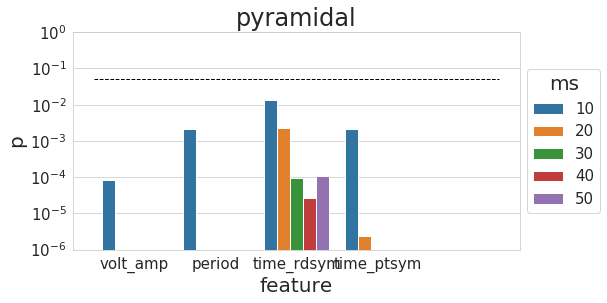

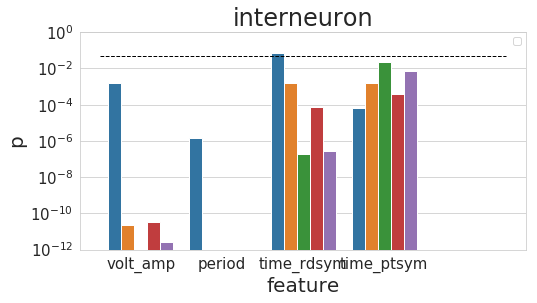

In [16]:
# Visualize significance
plt.figure(figsize=(8,4))
sns.barplot(x='feature', y='p', hue='ms',
            data=df_sig[df_sig['neu']=='pyramidal'])
plt.plot([-.5,4.5], [.05,.05], 'k--')
plt.ylim(10e-7, 1)
plt.gca().set_yscale('log')
legend = plt.legend(fontsize=15, loc='center left',
                    bbox_to_anchor=(1, 0.5), title='ms')
legend.get_title().set_fontsize('20')
plt.title('pyramidal')

plt.figure(figsize=(8,4))
sns.barplot(x='feature', y='p', hue='ms',
            data=df_sig[df_sig['neu']=='interneuron'])
plt.plot([-.5,4.5], [.05,.05], 'k--')
plt.gca().set_yscale('log')
plt.ylim(10e-13, 1)
plt.legend([])
plt.title('interneuron')

### Apply FDR correction
https://brainder.org/2011/09/05/fdr-corrected-fdr-adjusted-p-values/

Note because all pvalues are significant, the FDR corrected pvalues are the same as the original

Basically just mulitply each pvalue by m/k
    * m = number of tests
    * k = rank of the test (1 = lowest p value)
    * but cannot go above the next adjusted pval
        * nonmonotonicity correction

In [17]:
from statsmodels.stats import multitest
multitest.fdrcorrection(df_sig[df_sig['ms']==ms]['p'])

(array([ True,  True,  True,  True,  True,  True,  True,  True]),
 array([1.45725522e-09, 2.20190650e-16, 2.20976935e-03, 3.78949168e-06,
        5.80934766e-11, 1.33429903e-17, 1.82521150e-03, 1.82521150e-03]))

### Sequence between P and I neurons

In [18]:
dict_sig_pi = defaultdict(list)
df_type = df_neu_pairs_raw[((df_neu_pairs_raw['clu1_type']=='p') &
                           (df_neu_pairs_raw['clu2_type']=='i')) |
                           ((df_neu_pairs_raw['clu1_type']=='i') &
                            (df_neu_pairs_raw['clu2_type']=='p'))]
for twindow in twindows:
    df_temp = df_type[df_type['synchrony_ms']==twindow]
    df_temp = df_temp[df_temp['N_spikes_cycle_sequence']>=min_N_sync_spikes]
    for feat in feats:
        x = df_temp[feat+'_seqprepost_p']
        p = stats.binom_test((x<.05).sum(), len(x), p=p_cutoff)
        conf_int = proportion_confint((x<.05).sum(), len(x), method = 'binom_test')
        dict_sig_pi['ms'].append(twindow)
        dict_sig_pi['feature'].append(feat)
        dict_sig_pi['p'].append(p)
        dict_sig_pi['N_significant'].append((x<.05).sum())
        dict_sig_pi['fraction_significant'].append((x<.05).sum()/len(x))
        dict_sig_pi['N'].append(len(x))
        dict_sig_pi['conf_int_low'].append(conf_int[0])
        dict_sig_pi['conf_int_hi'].append(conf_int[1])
df_sig_pi = pd.DataFrame(dict_sig_pi)
df_sig_pi.head(10)

,ms,feature,p,N_significant,fraction_significant,N,conf_int_low,conf_int_hi
0,10,volt_amp,2.484860e-10,52,0.132316,393,0.098855,0.166424
1,10,period,3.471763e-17,65,0.165394,393,0.130703,0.205861
2,10,time_rdsym,1.760636e-08,48,0.122137,393,0.092524,0.158741
3,10,time_ptsym,1.114671e-06,44,0.111959,393,0.083606,0.147291
4,20,volt_amp,4.189190e-19,72,0.167053,431,0.134312,0.205137
5,20,period,4.031018e-22,77,0.178654,431,0.144752,0.217893
6,20,time_rdsym,2.050555e-05,43,0.099768,431,0.073878,0.131973
7,20,time_ptsym,1.103029e-09,54,0.125290,431,0.096657,0.159859
8,30,volt_amp,3.482064e-22,77,0.179070,430,0.145089,0.218400
9,30,period,2.237381e-25,82,0.190698,430,0.155551,0.231185


No handles with labels found to put in legend.


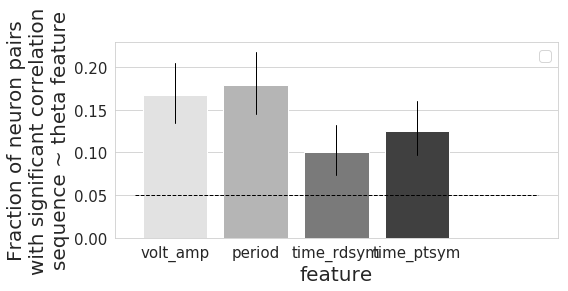

In [19]:
# Visualize significance
df_plt = df_sig_pi[df_sig_pi['ms']==ms]
plt.figure(figsize=(8,4))
sns.barplot(x='feature', y='fraction_significant',
            data=df_plt, palette='Greys')

# Plot error bars
for i, feat in enumerate(feats):
    cf_low = df_plt[df_plt['feature']==feat]['conf_int_low'].values[0]
    cf_hi = df_plt[df_plt['feature']==feat]['conf_int_hi'].values[0]
    plt.plot([i,i], [cf_low, cf_hi], 'k-')
legend = plt.legend(fontsize=15)
plt.plot([-.5,4.5], [.05,.05], 'k--')
plt.ylabel('Fraction of neuron pairs\nwith significant correlation\nsequence ~ theta feature')
plt.tight_layout()

In [20]:
# Print pvals
df_sig_pi[df_sig_pi['ms']==ms]

,ms,feature,p,N_significant,fraction_significant,N,conf_int_low,conf_int_hi
4,20,volt_amp,4.189190e-19,72,0.167053,431,0.134312,0.205137
5,20,period,4.031018e-22,77,0.178654,431,0.144752,0.217893
6,20,time_rdsym,2.050555e-05,43,0.099768,431,0.073878,0.131973
7,20,time_ptsym,1.103029e-09,54,0.125290,431,0.096657,0.159859
